In [10]:
# 1. Carregando as bibliotecas base
import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import multiprocessing

from transformers import RobertaModel, RobertaTokenizer
import torch
import joblib


import scripts.preprocess as pp
import scripts.embeddings as eb
import scripts.convert as cv

reload(cv)
reload(pp)
reload(eb)

<module 'scripts.embeddings' from '/mnt/c/Users/luanm/projects/pece-monografia/src/models/scripts/embeddings.py'>

In [11]:
# 2. Carregar base de commits que será tratada

# Transformar blocos de código em commits
cv.convert_to_jsonl('./code_snippets', './inputs/commits.jsonl')

# Definir dataframe
df = pd.read_json('./inputs/commits.jsonl', lines=True)
df_labels = pd.read_csv('./inputs/labels.csv', sep=',')

labels = df_labels['Label']

print(f"Trecho de código com maior tamanho: {df['new_contents'].str.len().min()}\n")
print(f"Trecho de código com maior tamanho: {df['new_contents'].str.len().max()}\n")
print(f"Tamanho dos labels: {len(labels)}\n")

df.describe()

['GeneratedClass_1.cs', 'GeneratedClass_2.cs', 'GeneratedClass_3.cs', 'GeneratedClass_4.cs', 'GeneratedClass_5.cs', 'GeneratedClass_6.cs', 'GeneratedClass_7.cs', 'GeneratedClass_8.cs', 'GeneratedClass_9.cs', 'GeneratedClass_10.cs', 'GeneratedClass_11.cs', 'GeneratedClass_12.cs', 'GeneratedClass_13.cs', 'GeneratedClass_14.cs', 'GeneratedClass_15.cs', 'GeneratedClass_16.cs', 'GeneratedClass_17.cs', 'GeneratedClass_18.cs', 'GeneratedClass_19.cs', 'GeneratedClass_20.cs', 'GeneratedClass_21.cs', 'GeneratedClass_22.cs', 'GeneratedClass_23.cs', 'GeneratedClass_24.cs', 'GeneratedClass_25.cs', 'GeneratedClass_26.cs', 'GeneratedClass_27.cs', 'GeneratedClass_28.cs', 'GeneratedClass_29.cs', 'GeneratedClass_30.cs', 'GeneratedClass_31.cs', 'GeneratedClass_32.cs', 'GeneratedClass_33.cs', 'GeneratedClass_34.cs', 'GeneratedClass_35.cs', 'GeneratedClass_36.cs', 'GeneratedClass_37.cs', 'GeneratedClass_38.cs', 'GeneratedClass_39.cs', 'GeneratedClass_40.cs', 'GeneratedClass_41.cs', 'GeneratedClass_42.cs', 

,new_contents
count,115
unique,108
top,
freq,5


In [12]:
# 3. Preprocessar commits
df['new_contents'] = df['new_contents'].apply(pp.clean_code_bert)

df.head()

,new_contents
0,
1,<NEWLINE> <NEWLINE> <NEWLINE> <NEWLINE> <...
2,
3,[TestFixture] <NEWLINE>
4,public string SceneName <NEWLINE> <NEWLINE>


In [13]:
# 4. Escrever dataframe em csv para validação
df.to_csv('./outputs/data_preprocessed.csv', sep=";", index=False)

x_cleaned = df['new_contents']

In [14]:
# 5. Tokenização e geração dos embenddings
## Utilizando o codebert como tokenizador e criador do vetor (embeddings)
model = RobertaModel.from_pretrained("microsoft/codebert-base")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")

def get_code_embedding_based_on_cls(code):
    inputs = tokenizer(code, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():   
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Converter os snippets de código em embeddings
x_vecs = [get_code_embedding_based_on_cls(code) for code in x_cleaned]

print(f"Tamanho da matriz de vetores: {np.array(x_vecs).shape}")

Tamanho da matriz de vetores: (115, 768)


In [15]:
# 7. Treinar SVM com GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(
    x_vecs, 
    labels, 
    test_size=0.3, 
    random_state=98, 
    stratify=labels)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

clf = svm.SVC()

param_grid = {
    'C': [0.1, 1, 10],  # Regularização
    'kernel': ['linear', 'rbf'],  # Função de kernel
    'gamma': ['scale', 'auto'],  # Parâmetro do kernel
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=2, scoring='f1_macro')

# Treinando o modelo com Grid Search
grid_search.fit(X_train_scaled, y_train)

# Melhor combinação de hiperparâmetros encontrada
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print(f"Melhores parâmetros: {grid_search.best_params_}")
print(classification_report(y_test, y_pred,zero_division=0))


Melhores parâmetros: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        26
           1       1.00      0.75      0.86         4
           2       1.00      1.00      1.00         2
           3       1.00      0.33      0.50         3

    accuracy                           0.91        35
   macro avg       0.97      0.77      0.83        35
weighted avg       0.92      0.91      0.90        35



In [16]:
# 8. Treinar RandomForest com GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(x_vecs, labels, test_size=0.3, random_state=98, stratify=labels)

# Instanciando o classificador Random Forest
rf = RandomForestClassifier(random_state=42)

# Definir os parâmetros para o GridSearch
param_grid = {
    'n_estimators': [10, 50, 100, 200],        # Número de árvores na floresta
    'max_depth': [None, 10, 20, 30],           # Profundidade máxima das árvores
    'min_samples_split': [2, 5, 10],           # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],             # Mínimo de amostras por folha
    'bootstrap': [True, False],                # Usar amostragem bootstrap
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
    cv=2, scoring='f1_macro')

# Treinando com o GridSearch
grid_search.fit(X_train, y_train)

# Melhor combinação de hiperparâmetros encontrada
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Melhores parâmetros: {grid_search.best_params_}")

print(classification_report(y_test, y_pred, zero_division=0))

Melhores parâmetros: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        26
           1       1.00      0.25      0.40         4
           2       0.00      0.00      0.00         2
           3       1.00      0.33      0.50         3

    accuracy                           0.80        35
   macro avg       0.70      0.40      0.45        35
weighted avg       0.79      0.80      0.74        35



In [17]:
# 9. Treinar XGBoost com GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(x_vecs, labels, test_size=0.3, random_state=98, stratify=labels)

clf = xgb.XGBClassifier(eval_metric='mlogloss')

param_grid = {
    'n_estimators': [50, 100],              # Número de árvores
    'max_depth': [3, 10],                   # Profundidade máxima das árvores
    'learning_rate': [0.01, 0.1],           # Taxa de aprendizado
    'subsample': [0.8, 1.0],                # Subamostragem
    'colsample_bytree': [0.8, 1.0],         # Colunas usadas em cada árvore
    'gamma': [0.1, 0.5],                    # Regularização para reduzir overfitting
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=clf, param_grid=param_grid, 
    scoring='f1_macro', cv=2)

# Treinando com o GridSearch
grid_search.fit(X_train, y_train)

# Melhor combinação de hiperparâmetros encontrada
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Melhores parâmetros: {grid_search.best_params_}")

print(classification_report(y_test, y_pred, zero_division=0))

Melhores parâmetros: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        26
           1       1.00      0.50      0.67         4
           2       0.00      0.00      0.00         2
           3       1.00      0.33      0.50         3

    accuracy                           0.83        35
   macro avg       0.70      0.46      0.52        35
weighted avg       0.80      0.83      0.79        35



[0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 3 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 2 2 2 2 2 2
 3 3 3 3]


['./outputs/scaler.pkl']

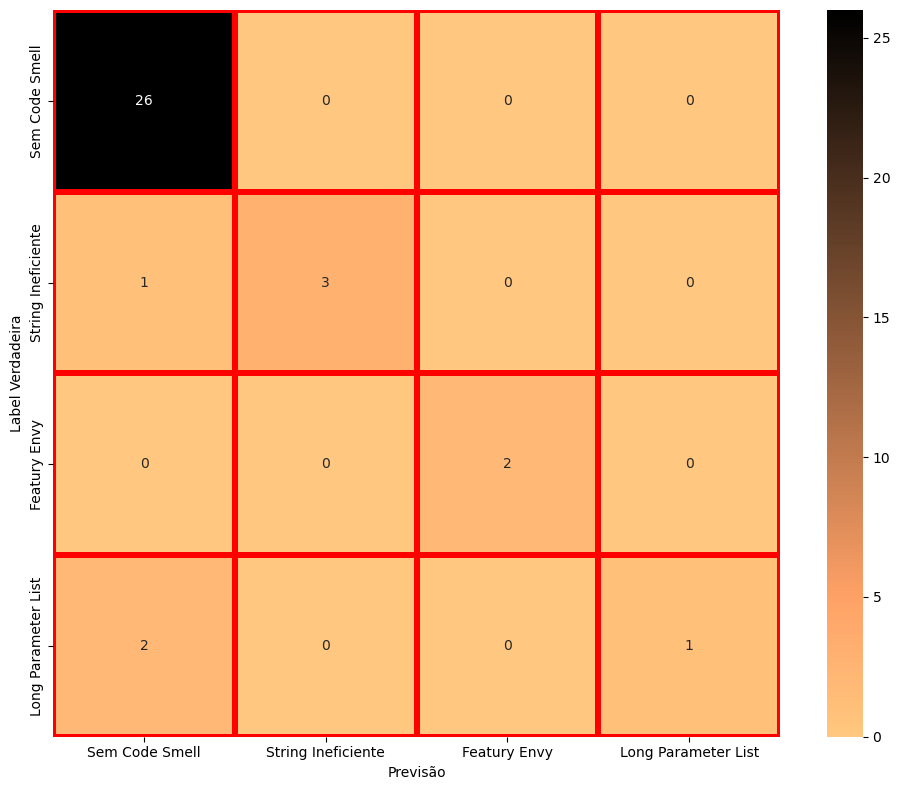

In [18]:
# 10. DUMP - Exportar melhor modelo 'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'
X_train, X_test, y_train, y_test = train_test_split(x_vecs, labels, test_size=0.3, random_state=98, stratify=labels)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

s = svm.SVC(C=0.1, gamma='scale', kernel='linear')

s.fit(X_train_scaled, y_train)

y_pred = s.predict(X_test_scaled)

print(s.predict(scaler.transform(x_vecs)))

## Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8)) 

sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap="copper_r",
            linewidths=3,
            linecolor="r",
            square=True,
            xticklabels=['Sem Code Smell', "String Ineficiente", "Featury Envy", "Long Parameter List"], 
            yticklabels=['Sem Code Smell', "String Ineficiente", "Featury Envy", "Long Parameter List"])

plt.ylabel('Label Verdadeira')
plt.xlabel('Previsão')
plt.tight_layout()
plt.savefig('./outputs/confusion_matrix.png')

joblib.dump(s, './outputs/svm_cbb.pkl')
joblib.dump(scaler, './outputs/scaler.pkl')